In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [5]:
def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [6]:
house_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/house.csv")
print(house_df.shape)
house_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [7]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# https://www.kaggle.com/code/emmanueldjegou/house-prices-advanced-regression-techniques/notebook
house_df = house_df[[
    "SalePrice",  # target
    "OverallQual",
    "GrLivArea",
    "TotalBsmtSF",
    "GarageCars",
    "BsmtFinSF1",
    "Fireplaces",
    "Foundation",
    "BsmtQual",
    "KitchenQual",
    "WoodDeckSF",
    "LotShape",
    "Neighborhood",
    "HouseStyle",
    "SaleCondition",
]]

In [9]:
na_stat(house_df)

Series([], dtype: int64)

In [10]:
duplicates_stat(house_df)

SalePrice  OverallQual  GrLivArea  TotalBsmtSF  GarageCars  BsmtFinSF1  Fireplaces  Foundation  BsmtQual  KitchenQual  WoodDeckSF  LotShape  Neighborhood  HouseStyle  SaleCondition
151000     7            1200       600          2           0           0           PConc       Gd        Gd           0           Reg       Somerst       2Story      Normal           1
dtype: int64

In [11]:
house_df = house_df.drop_duplicates()
duplicates_stat(house_df)

Series([], dtype: int64)

In [12]:
count_categories(house_df)

Foundation        6
BsmtQual          5
KitchenQual       4
LotShape          4
Neighborhood     25
HouseStyle        8
SaleCondition     6
dtype: int64

In [13]:
print(house_df.shape)
house_df.head()

(1459, 15)


,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,BsmtFinSF1,Fireplaces,Foundation,BsmtQual,KitchenQual,WoodDeckSF,LotShape,Neighborhood,HouseStyle,SaleCondition
0,208500,7,1710,856,2,706,0,PConc,Gd,Gd,0,Reg,CollgCr,2Story,Normal
1,181500,6,1262,1262,2,978,1,CBlock,Gd,TA,298,Reg,Veenker,1Story,Normal
2,223500,7,1786,920,2,486,1,PConc,Gd,Gd,0,IR1,CollgCr,2Story,Normal
3,140000,7,1717,756,3,216,1,BrkTil,TA,Gd,0,IR1,Crawfor,2Story,Abnorml
4,250000,8,2198,1145,3,655,1,PConc,Gd,Gd,192,IR1,NoRidge,2Story,Normal


In [14]:
class HouseDataset(Dataset):
    encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "SalePrice"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [15]:
train_df, test_df = train_test_split(house_df, test_size=0.2, random_state=0)

train_dataset = HouseDataset(train_df)
test_dataset = HouseDataset(
    test_df,
    encoder=train_dataset.encoder,
    scaler=train_dataset.scaler,
)
len(train_dataset), len(test_dataset), train_dataset.num_features

(1167, 292, 14)

## Построение и обучение модели

In [16]:
def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_r2s = [], []
    test_losses, test_r2s = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_r2 = train_loop(train_dataloader, model, loss_fn, optimizer, verbose=verbose, device=device)
        print(f"Train Error: loss: {train_loss:.6f}, R^2: {train_r2:.4f}")
        train_losses.append(train_loss)
        train_r2s.append(train_r2)

        test_loss, test_r2 = test_loop(test_dataloader, model, loss_fn, device=device)
        print(f" Test Error: loss: {test_loss:.6f}, R^2: {test_r2:.4f}\n")
        test_losses.append(test_loss)
        test_r2s.append(test_r2)

        torch.cuda.empty_cache()
    return train_losses, train_r2s, test_losses, test_r2s


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_r2 = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, R^2: {r2:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_r2 / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.r2_score(y_true, y_pred)


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)).cpu(), torch.flatten(torch.vstack(y_pred)).cpu()


def plot_train_test(
        train_losses: t.List[float],
        train_r2s: t.List[float],
        test_losses: t.List[float],
        test_r2s: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_r2s)
    axes[1].plot(epochs, test_r2s)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("$R^2$")


def plot_y_true_y_pred(y_true: torch.Tensor, y_pred: torch.Tensor):
    x = torch.arange(len(y_pred))
    plt.plot(x, y_true)
    plt.plot(x, y_pred)
    plt.legend(["true", "pred"])

In [17]:
class HouseRegression(nn.Module):

    def __init__(self, num_features: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)

In [18]:
torch.manual_seed(0)

net = HouseRegression(train_dataset.num_features).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0025)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

HouseRegression(
  (mlp): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [19]:
%%time

train_losses, train_r2s, test_losses, test_r2s = common_train(
    epochs=700,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 39328296960.000000, R^2: -5.3592
 Test Error: loss: 37720154112.000000, R^2: -5.0340

Epoch 2
--------------------------------
Train Error: loss: 36024377344.000000, R^2: -5.1423
 Test Error: loss: 30396688384.000000, R^2: -3.8624

Epoch 3
--------------------------------
Train Error: loss: 23942193152.000000, R^2: -2.6027
 Test Error: loss: 8213587456.000000, R^2: -0.3139

Epoch 4
--------------------------------
Train Error: loss: 7298099712.000000, R^2: -0.3074
 Test Error: loss: 7315141120.000000, R^2: -0.1702

Epoch 5
--------------------------------
Train Error: loss: 6002701824.000000, R^2: 0.0098
 Test Error: loss: 4594213888.000000, R^2: 0.2651

Epoch 6
--------------------------------
Train Error: loss: 4189750528.000000, R^2: 0.3391
 Test Error: loss: 3133531904.000000, R^2: 0.4987

Epoch 7
--------------------------------
Train Error: loss: 3043065088.000000, R^2: 0.4976
 Test Error: loss: 2743749632.000000, R^2: 0

## Оценка и выводы

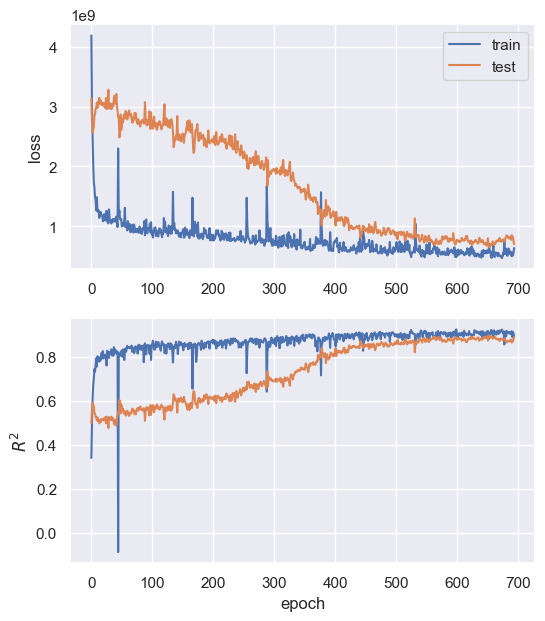

In [20]:
plot_train_test(train_losses[5:], train_r2s[5:], test_losses[5:], test_r2s[5:])

In [21]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)  # тоже самое что и nn.MSELoss
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
print(f"  R^2: {r2:.6f}")
print(f"  MSE: {mse:.6f}")
print(f" RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f" MAPE: {mape:.6f}")
print(f"RMSLE: {rmsle:.6f}")

  R^2: 0.888382
  MSE: 697758336.000000
 RMSE: 26415.115234
  MAE: 18370.394531
 MAPE: 0.113613
RMSLE: 0.150505


In [1]:
plot_y_true_y_pred(y_true[:100], y_pred[:100])

NameError: name 'plot_y_true_y_pred' is not defined

In [23]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0)).squeeze(0)
    print(f"Input:   {x.cpu()}")
    print(f"Target:  {y.item():.6f}")
    print(f"Predict: {pred.item():.6f}\n")

Input:   tensor([ 0.6663,  0.2584,  1.1062,  0.3007,  2.4455,  0.5949,  2.0000,  2.0000,
         2.0000, -0.1037,  3.0000, 20.0000,  7.0000,  4.0000])
Target:  275000.000000
Predict: 257002.078125

Input:   tensor([ 0.6663,  1.4568, -0.2671,  0.3007, -0.3389,  0.5949,  2.0000,  2.0000,
         2.0000,  1.0492,  0.0000,  8.0000,  5.0000,  4.0000])
Target:  236000.000000
Predict: 236515.609375

Input:   tensor([-0.0686,  1.3491, -0.8859,  0.3007, -1.0246,  0.5949,  1.0000,  2.0000,
         2.0000,  3.9473,  0.0000,  7.0000,  7.0000,  2.0000])
Target:  274970.000000
Predict: 186982.875000

Input:   tensor([-0.8035, -0.7891, -1.6745, -1.0544, -0.2268, -0.9618,  1.0000,  4.0000,
         3.0000, -0.4639,  3.0000, 12.0000,  7.0000,  4.0000])
Target:  139000.000000
Predict: 112669.289062

Input:   tensor([-0.8035, -0.7402, -0.1264, -1.0544,  0.3195, -0.9618,  1.0000,  4.0000,
         3.0000, -0.7441,  3.0000, 12.0000,  2.0000,  3.0000])
Target:  135000.000000
Predict: 117122.085938

